In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import isnan

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Generate Networkx graph

In [3]:

# G = nx.read_gml('datasets/verified.gml')
G = nx.read_gml('datasets/unverified.gml')

In [4]:
G.number_of_nodes(), G.number_of_edges()

(3454, 20018)

## Features dataset

In [5]:

# df = pd.read_csv("datasets/verified_features_all_300k.csv")
df = pd.read_csv("datasets/unverified_features_all_4k.csv")



In [6]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,14669951,DRUDGE_REPORT,2,1378378,21171,237720,0.0,0.000000,0.000000,0.125000,...,0.000000,0.015625,0.000000,0.012500,0.031250,0.0,0.015625,0.000000,0.015625,0.03125
1,1754641,nytimesbusiness,441,786324,14641,206786,0.0,0.227273,0.068182,0.145455,...,0.000000,0.000000,0.018182,0.000000,0.007576,0.0,0.033333,0.000000,0.000000,0.00000
2,3863605355,historylvrsclub,0,544773,5041,252317,1.0,0.333333,0.100000,0.097059,...,0.000000,0.016340,0.000000,0.000891,0.000000,0.0,0.000000,0.000000,0.000000,0.00000
3,53036660,GLAMOUR_sa,862,500682,355,36609,1.0,0.708333,0.416667,0.336111,...,0.000000,0.000000,0.000000,0.000000,0.013889,0.0,0.000000,0.016667,0.000000,0.00000
4,270106571,brotips,58,464707,1504,87848,1.0,0.950000,0.750000,0.174709,...,0.006993,0.000000,0.000000,0.004049,0.000000,0.0,0.000000,0.029304,0.000000,0.00000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3187 entries, 0 to 3186
Columns: 205 entries, uid to musical_empath
dtypes: float64(199), int64(5), object(1)
memory usage: 5.0+ MB


### If some nodes are there in the graph but missing from the features dataset or vice versa, remove those nodes

In [8]:
names = list(df['name'].values)

In [9]:
sub_g = G.subgraph(names)

In [10]:
sub_g.number_of_nodes(), sub_g.number_of_edges()

(3088, 17399)

In [11]:
# df[]
nodes = list(sub_g.nodes())

df = df[df['name'].isin(nodes)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3088 entries, 0 to 3186
Columns: 205 entries, uid to musical_empath
dtypes: float64(199), int64(5), object(1)
memory usage: 4.9+ MB


In [12]:
df = df[df['name'].isin(nodes)]
names = list(df['name'].values)


In [13]:
names[0]

'DRUDGE_REPORT'

In [14]:
# int(df['fake'][df['name'] == names[0]])
len(names)

3088

In [15]:
# G.node['PTorresTV']

### Add the labels to the nodes as attributes
These labels will come in handy while doing analysis in Gephi

In [16]:
for n in names:
    G.node[n]['fake'] = int(df['fake'][df['name'] == n])

In [17]:
# G.node['PTorresTV']
# nx.write_gml(G, "datasets/verified_fake_labels.gml")

### Use power transform
Since most of the features have a log-normal distribution, a power scalar is used to transform it into a gausian distribution

In [18]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True)

# pt = StandardScaler()

In [19]:
# values = df.drop(columns=['name', 'fake']).values
values = df.drop(columns=['name', 'fake', 'uid']).values

values_log = pt.fit_transform(values)

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [20]:
df = df.reindex(columns=['fake'] + [ x for x in df.columns if x!='fake'])

In [21]:
# df[df.columns[3:]]
# df[df.columns[2:]]

In [22]:
# df[df.columns[2:]] = values_log
df[df.columns[3:]] = values_log
df.head()

,fake,uid,name,friends_count,followers_count,listed_count,statuses_count,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0.0,14669951,DRUDGE_REPORT,-2.097107,0.0,4.467606,0.826057,-1.002952,-0.492105,-1.369532,...,-0.767252,0.375033,-0.467754,2.327420,1.978583,-0.345026,1.254210,-0.797654,1.534767,1.729832
1,0.0,1754641,nytimesbusiness,-1.116964,0.0,4.146302,0.703427,0.152129,-0.191963,-1.169158,...,-0.767252,-1.212191,2.526159,-0.515848,1.381948,-0.345026,1.858396,-0.797654,-0.965242,-1.007153
2,1.0,3863605355,historylvrsclub,-2.146787,0.0,3.242603,0.878808,0.506724,-0.057281,-1.651190,...,-0.767252,0.427470,-0.467754,0.753339,-0.787835,-0.345026,-0.876561,-0.797654,-0.965242,-1.007153
3,1.0,53036660,GLAMOUR_sa,-0.750339,0.0,1.149412,-0.732859,1.289232,1.132633,0.495821,...,-0.767252,-1.212191,-0.467754,-0.515848,1.813891,-0.345026,-0.876561,1.827484,-0.965242,-1.007153
4,1.0,270106571,brotips,-1.757589,0.0,2.261449,-0.026381,1.579261,2.167533,-0.890684,...,1.331937,-1.212191,-0.467754,2.133314,-0.787835,-0.345026,-0.876561,1.969416,-0.965242,-1.007153


After the power transform

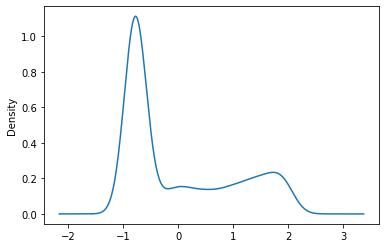

In [23]:
ax = plt.gca()

df['money_empath'].plot.kde()

plt.show()


In [24]:
df.index = df.index.map(str)
df = df.set_index('name')

In [25]:
df.index.names = [None]

In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3088 entries, DRUDGE_REPORT to THUTO
Columns: 204 entries, fake to musical_empath
dtypes: float64(203), int64(1)
memory usage: 4.8+ MB
None


In [27]:
# user_features
# train_data

In [28]:
df = df.astype({'fake': int})

In [29]:
user_features = df.drop(columns=['fake', 'uid'])
# user_features = df.drop(columns=['fake'])

user_target = df['fake']

## Graph Neural Networks

### Split into training and testing sets

In [30]:
train_data, test_data, train_targets, test_targets = train_test_split(user_features,
                                         user_target,
                                         test_size=0.2,
                                         random_state=1)

train_targets= train_targets.values.reshape((-1,1))
test_targets= test_targets.values.reshape((-1,1))


train_targets.shape, test_targets.shape, train_data.shape, test_data.shape

((2470, 1), (618, 1), (2470, 202), (618, 202))

In [31]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

### Create the model

In [58]:
model_type = 'graphsage'    # Can be either gcn, gat, or graphsage


In [146]:

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50; 
    num_samples = [10, 5]
    epochs = 50
    
    generator = GraphSAGENodeGenerator(stg, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)
    
    base_model = GraphSAGE(
        layer_sizes=[32, 32],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gcn":
    # For GCN model
    epochs = 100 
    
    generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets, )
    
    base_model = GCN(
        layer_sizes=[128, 128],
        generator = generator,
        bias=True,
        dropout=0.2,
        activations=["elu", "elu"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    
elif model_type == "gat":
    # For GAT model
    layer_sizes = [32, 1]
    attention_heads = 32
    epochs = 20
    
    generator = FullBatchNodeGenerator(stg, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets,)
    
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.node_model()

In [147]:

model = Model(inputs=x_inp, outputs=prediction)

In [148]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [149]:
test_gen = generator.flow(test_data.index, test_targets)

In [150]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,  patience=30)

### Train

In [151]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    verbose=1,
    callbacks=[es],
    shuffle=False,
)

Epoch 1/50
50/50 [==============================] - 162s 3s/step - loss: 0.6945 - acc: 0.5208 - val_loss: 0.6834 - val_acc: 0.5777
Epoch 2/50
50/50 [==============================] - 18s 359ms/step - loss: 0.6870 - acc: 0.5494 - val_loss: 0.6885 - val_acc: 0.5275
Epoch 3/50
50/50 [==============================] - 16s 329ms/step - loss: 0.6820 - acc: 0.5586 - val_loss: 0.6943 - val_acc: 0.5372
Epoch 4/50
50/50 [==============================] - 19s 388ms/step - loss: 0.6664 - acc: 0.5970 - val_loss: 0.7018 - val_acc: 0.5275
Epoch 5/50
50/50 [==============================] - 50s 1s/step - loss: 0.6624 - acc: 0.6014 - val_loss: 0.6982 - val_acc: 0.5388
Epoch 6/50
50/50 [==============================] - 47s 934ms/step - loss: 0.6517 - acc: 0.6242 - val_loss: 0.6990 - val_acc: 0.5583
Epoch 7/50
50/50 [==============================] - 17s 333ms/step - loss: 0.6406 - acc: 0.6232 - val_loss: 0.7213 - val_acc: 0.5680
Epoch 8/50
50/50 [==============================] - 16s 322ms/step - loss:

In [152]:

# test_metrics = model.evaluate_generator(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

### Plot training and validation

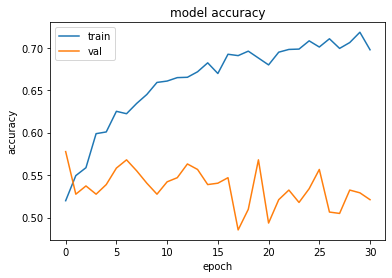

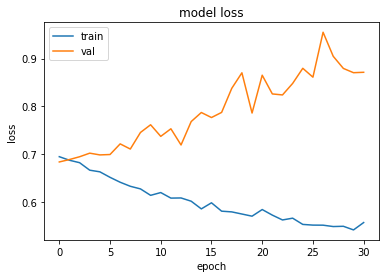

In [153]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Calculate evaluation metrics

In [67]:

all_nodes = df.drop(columns=['fake','uid']).index
all_gen = generator.flow(all_nodes)

In [68]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [69]:
all_predictions.shape

(3088, 1)

In [70]:
# df.drop(columns=['fake'])

In [71]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)

In [72]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [73]:

test_preds.head()

,0
AaronRFernandes,0.611768
ActorsRedCarpet,0.662154
gaymlm,0.347149
GeorgeMentz,0.687916
alhajassam,0.699302


In [74]:
from numpy import isnan
test_predictions = test_preds.values
where_are_NaNs = isnan(test_predictions)
test_predictions[where_are_NaNs] = 0
test_predictions_class = ((test_predictions>=0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5642550628623052


In [75]:
# test_df['Predicted_score'].values
# test_predictions_class
# test_df['True'].values

In [76]:

pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,107,152
1,114,245


In [77]:
print(classification_report(test_df['True'], test_df['Predicted_class']))

              precision    recall  f1-score   support

           0       0.48      0.41      0.45       259
           1       0.62      0.68      0.65       359

    accuracy                           0.57       618
   macro avg       0.55      0.55      0.55       618
weighted avg       0.56      0.57      0.56       618



In [78]:

print('Accuracy: %f' % accuracy_score(test_df['True'], test_df['Predicted_class']))
print('Precision: %f' % precision_score(test_df['True'], test_df['Predicted_class']))
print('Recall: %f' % recall_score(test_df['True'], test_df['Predicted_class']))
print('F1 score: %f' % f1_score(test_df['True'], test_df['Predicted_class']))

# confusion matrix
# print(confusion_matrix(test_df['True'], test_df['Predicted_class']))

Accuracy: 0.569579
Precision: 0.617128
Recall: 0.682451
F1 score: 0.648148


## Visualize learnt embeddings

In [79]:
model.layers

In [80]:
if model_type == 'graphsage':
    # For GraphSAGE, we are going to use the output activations 
    # of the second GraphSAGE layer as the node embeddings
    # x_inp, prediction
    emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
    emb = emb_model.predict_generator(generator=all_gen, )
elif model_type == 'gcn':
    # For GCN, we are going to use the output activations of 
    # the second GCN layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == 'gat':
    # For GAT, we are going to use the output activations of the 
    # first Graph Attention layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)

In [81]:
emb.shape

(3088, 1, 32)

In [82]:
emb = emb.squeeze()

In [83]:
if model_type == "graphsage":
    emb_all_df = pd.DataFrame(emb, index=df.index)
elif model_type == "gcn" or model_type == "gat":
    emb_all_df = pd.DataFrame(emb, index=stg.nodes())

In [84]:
emb_test = emb_all_df.loc[test_data.index, :]

In [85]:
X = emb_test
y = test_targets
X.shape

(618, 32)

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [87]:
transform = TSNE # or use PCA 

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed['label'] = y

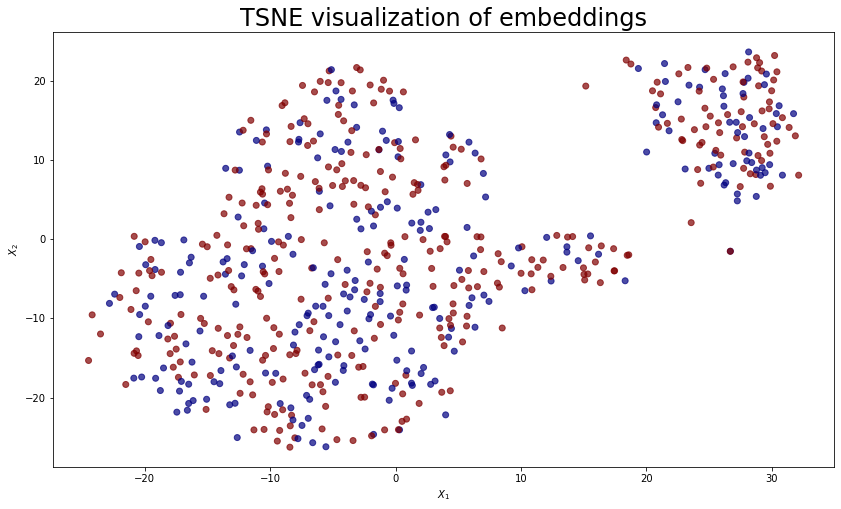

In [88]:

alpha = 0.7

fig, ax = plt.subplots(figsize=(14,8,))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of embeddings'.format(transform.__name__), fontsize=24)
plt.show()

## Compare GNN with Logistic regression, SVM, XGBoost and Random forest

In [89]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

### Naive Bayes

In [90]:
gnb = GaussianNB()

In [91]:
gnb.fit(train_data, train_targets.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [92]:
y_pred = gnb.predict(test_data)

In [93]:
print(classification_report(test_targets, y_pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred))


              precision    recall  f1-score   support

           0       0.43      0.51      0.47       259
           1       0.59      0.52      0.55       359

    accuracy                           0.51       618
   macro avg       0.51      0.51      0.51       618
weighted avg       0.53      0.51      0.52       618

Accuracy: 0.5129449838187702


### KNN

In [94]:
knn = KNeighborsClassifier(n_neighbors=10)

In [95]:
knn.fit(train_data, train_targets.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [96]:
y_pred = knn.predict(test_data)

In [97]:
print(classification_report(test_targets, y_pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred))


              precision    recall  f1-score   support

           0       0.41      0.53      0.46       259
           1       0.57      0.44      0.50       359

    accuracy                           0.48       618
   macro avg       0.49      0.49      0.48       618
weighted avg       0.50      0.48      0.48       618

Accuracy: 0.48058252427184467


### Logistic regression

In [98]:
lr = LogisticRegressionCV(cv=5,  
                          max_iter=10000)

In [99]:
lr.fit(train_data, train_targets.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [100]:
test_preds_lr = lr.predict_proba(test_data)

In [101]:
# lr.score(test_data, test_targets)

In [102]:
# test_preds_lr[:, 1]

In [103]:
test_predictions_class_lr = ((test_preds_lr[:, 1]>=0.5)*1).flatten()
test_df_lr = pd.DataFrame({"Predicted_score": test_preds_lr[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr, 
                        "True": test_targets[:,0]})

In [104]:
pd.crosstab(test_df_lr['True'], test_df_lr['Predicted_class'])

Predicted_class,0,1
True,,
0,79,180
1,82,277


In [105]:
print(classification_report(test_targets, test_df_lr['Predicted_class']))
print("Accuracy:", accuracy_score(test_targets.ravel(), test_df_lr['Predicted_class']))


              precision    recall  f1-score   support

           0       0.49      0.31      0.38       259
           1       0.61      0.77      0.68       359

    accuracy                           0.58       618
   macro avg       0.55      0.54      0.53       618
weighted avg       0.56      0.58      0.55       618

Accuracy: 0.5760517799352751


### SVM

In [106]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(train_data, train_targets.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [107]:
y_pred = clf.predict(test_data)

In [108]:
print(classification_report(test_targets, y_pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred))


              precision    recall  f1-score   support

           0       0.48      0.38      0.42       259
           1       0.61      0.70      0.65       359

    accuracy                           0.56       618
   macro avg       0.54      0.54      0.54       618
weighted avg       0.55      0.56      0.56       618

Accuracy: 0.5647249190938511


### XGBoost

In [109]:
xgb_clf = xgb.XGBClassifier()

In [110]:
xgb_clf.fit(train_data, train_targets.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [111]:
pred = xgb_clf.predict(test_data)

In [112]:
print(classification_report(test_targets, pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), pred))

              precision    recall  f1-score   support

           0       0.49      0.46      0.47       259
           1       0.63      0.65      0.64       359

    accuracy                           0.57       618
   macro avg       0.56      0.55      0.55       618
weighted avg       0.57      0.57      0.57       618

Accuracy: 0.56957928802589


### Random Forest

In [113]:
forest = RandomForestClassifier()


In [114]:
forest.fit(train_data, train_targets.ravel())

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
pred = forest.predict(test_data)

In [116]:
print(classification_report(test_targets, pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), pred))

              precision    recall  f1-score   support

           0       0.48      0.62      0.54       259
           1       0.65      0.51      0.57       359

    accuracy                           0.56       618
   macro avg       0.56      0.57      0.56       618
weighted avg       0.58      0.56      0.56       618

Accuracy: 0.5566343042071198


## Logistic regression, SVM, XGBoost and Random forest with learnt embeddings

In [117]:
emb_train = emb_all_df.loc[train_data.index, :]

In [118]:
# train_data
# emb_train
feat_train = train_data.merge(emb_train, left_index=True, right_index=True, how='inner')

In [119]:
feat_test = test_data.merge(emb_test, left_index=True, right_index=True, how='inner')

### Naive bayes

In [120]:
gnb_emb = GaussianNB()

In [121]:
gnb_emb.fit(feat_train, train_targets.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [122]:
y_pred_emb = gnb_emb.predict(feat_test)

In [123]:
print(classification_report(test_targets, y_pred_emb))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred_emb))


              precision    recall  f1-score   support

           0       0.48      0.56      0.52       259
           1       0.64      0.56      0.60       359

    accuracy                           0.56       618
   macro avg       0.56      0.56      0.56       618
weighted avg       0.57      0.56      0.56       618

Accuracy: 0.5614886731391586


### KNN

In [124]:
knn_emb = KNeighborsClassifier(n_neighbors=10)

In [125]:
knn_emb.fit(feat_train, train_targets.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [126]:
y_pred_emb = knn_emb.predict(feat_test)

In [127]:
print(classification_report(test_targets, y_pred_emb))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred_emb))


              precision    recall  f1-score   support

           0       0.47      0.56      0.51       259
           1       0.63      0.54      0.58       359

    accuracy                           0.55       618
   macro avg       0.55      0.55      0.55       618
weighted avg       0.56      0.55      0.55       618

Accuracy: 0.5485436893203883


### Logistic regression

In [128]:
lr_emb = LogisticRegressionCV(cv=5,  
                          max_iter=10000)

In [129]:
lr_emb.fit(feat_train, train_targets.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [130]:
test_preds_lr_2 = lr_emb.predict_proba(feat_test)

In [131]:
# lr_emb.score(X, test_targets)

In [132]:
test_predictions_class_lr_2 = ((test_preds_lr_2[:, 1]>=0.5)*1).flatten()
test_df_lr_2 = pd.DataFrame({"Predicted_score": test_preds_lr_2[:, 1].flatten(), 
                        "Predicted_class": test_predictions_class_lr_2, 
                        "True": test_targets[:,0]})

In [133]:
pd.crosstab(test_df_lr_2['True'], test_df_lr_2['Predicted_class'])

Predicted_class,0,1
True,,
0,127,132
1,139,220


In [134]:
print(classification_report(test_targets, test_df_lr_2['Predicted_class']))
print("Accuracy:", accuracy_score(test_targets.ravel(), test_df_lr_2['Predicted_class']))

              precision    recall  f1-score   support

           0       0.48      0.49      0.48       259
           1       0.62      0.61      0.62       359

    accuracy                           0.56       618
   macro avg       0.55      0.55      0.55       618
weighted avg       0.56      0.56      0.56       618

Accuracy: 0.5614886731391586


### SVM

In [135]:
#Create a svm Classifier
clf_emb = svm.SVC(kernel='rbf', gamma='scale')
clf_emb.fit(feat_train, train_targets.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [136]:
y_pred_emb = clf_emb.predict(feat_test)

In [137]:
print(classification_report(test_targets, y_pred_emb))
print("Accuracy:", accuracy_score(test_targets.ravel(), y_pred_emb))

              precision    recall  f1-score   support

           0       0.45      0.47      0.46       259
           1       0.61      0.58      0.59       359

    accuracy                           0.54       618
   macro avg       0.53      0.53      0.53       618
weighted avg       0.54      0.54      0.54       618

Accuracy: 0.5372168284789643


### XGBoost

In [138]:
xgb_clf = xgb.XGBClassifier()

In [139]:
xgb_clf.fit(feat_train, train_targets.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [140]:
pred = xgb_clf.predict(feat_test)

In [141]:
print(classification_report(test_targets, pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), pred))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       259
           1       0.61      0.57      0.59       359

    accuracy                           0.54       618
   macro avg       0.53      0.53      0.53       618
weighted avg       0.54      0.54      0.54       618

Accuracy: 0.5355987055016181


### Random Forest

In [142]:
forest = RandomForestClassifier()


In [143]:
forest.fit(feat_train, train_targets.ravel())

/home/aveek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [144]:
pred = forest.predict(feat_test)

In [145]:
print(classification_report(test_targets, pred))
print("Accuracy:", accuracy_score(test_targets.ravel(), pred))

              precision    recall  f1-score   support

           0       0.47      0.58      0.51       259
           1       0.63      0.52      0.57       359

    accuracy                           0.55       618
   macro avg       0.55      0.55      0.54       618
weighted avg       0.56      0.55      0.55       618

Accuracy: 0.5453074433656958


## Cross validation using stratified K-fold

In [30]:
model_type = "gat"

In [31]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

In [32]:
if model_type == "graphsage":
    batch_size = 30
    num_samples = [20, 10]
    epochs = 50

    generator = GraphSAGENodeGenerator(stg, batch_size, num_samples)

elif model_type == "gcn":
    # For GCN model
    epochs = 100 
    
    generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
    
elif model_type == "gat":
    # For GAT model
    layer_sizes = [32, 1]
    attention_heads = 32
    epochs = 20

    generator = FullBatchNodeGenerator(stg, method="gat", sparse=True)
    
def create_model(train_data, train_targets):
    
    if model_type == "graphsage":
        train_gen = generator.flow(train_data.index, 
                                   train_targets, 
                                   shuffle=True)

        base_model = GraphSAGE(
            layer_sizes=[128, 128],
            generator=train_gen,
            bias=True,
            dropout=0.5,
        )
        x_inp, x_out = base_model.default_model(flatten_output=True)
        prediction = layers.Dense(units=1, activation="sigmoid")(x_out)

    elif model_type == "gcn":
        # For GCN model
        
        train_gen = generator.flow(train_data.index, 
                                   train_targets, )

        base_model = GCN(
            layer_sizes=[128, 128],
            generator = generator,
            bias=True,
            dropout=0.5,
            activations=["elu", "elu"]
        )
        x_inp, x_out = base_model.node_model()
        prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
        
        
    elif model_type == "gat":
        # For GAT model
        
        train_gen = generator.flow(train_data.index, 
                                   train_targets,)

        base_model = GAT(
            layer_sizes=layer_sizes,
            attn_heads=attention_heads,
            generator=generator,
            bias=True,
            in_dropout=0.5,
            attn_dropout=0.5,
            activations=["elu", "sigmoid"],
            normalize=None,
        )
        x_inp, prediction = base_model.node_model()
        
    model = Model(inputs=x_inp, outputs=prediction)
    return model, train_gen

In [33]:
list_of_lists = []
def test_model(test_data, test_targets):
    
    all_nodes = df.drop(columns=['fake','uid']).index
    all_gen = generator.flow(all_nodes)
    
    all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]
    all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)
    test_preds = all_predictions_df.loc[test_data.index, :]
    
    test_predictions = test_preds.values
    where_are_NaNs = isnan(test_predictions)
    test_predictions[where_are_NaNs] = 0
    test_predictions_class = ((test_predictions>=0.5)*1).flatten()
    test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                            "Predicted_class": test_predictions_class, 
                            "True": test_targets[:,0]})
    roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                    test_df['Predicted_score'].values)
    acc = accuracy_score(test_df['True'], test_df['Predicted_class'])
    prec = precision_score(test_df['True'], test_df['Predicted_class'])
    recall = recall_score(test_df['True'], test_df['Predicted_class'])
    f1 = f1_score(test_df['True'], test_df['Predicted_class'])
    
    list_of_lists.append([acc, prec,recall, f1, roc_auc])
    
    print('Test- ', 'Accuracy: %f' % acc, 'Precision: %f' % prec, 'Recall: %f' % recall, 'F1 score: %f' % f1 )
    print()

In [ ]:
folds = 10

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=folds, shuffle=True)
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(user_features, user_target)):
    print ("Training on fold " + str(index+1) + "/" + str(folds) +"...")
    # Generate batches from indices
    train_data, train_targets = user_features.iloc[train_indices], user_target.iloc[train_indices]
    test_data, test_targets = user_features.iloc[val_indices], user_target.iloc[val_indices]
    train_targets= train_targets.values.reshape((-1,1))
    test_targets= test_targets.values.reshape((-1,1))
    # Clear model, and create it
    model = None
    model, train_gen = create_model(train_data, train_targets)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),
        loss=losses.binary_crossentropy,
        metrics=["acc"],
    )
    
#     model.compile(
#         optimizer='adam',
#         loss='binary_crossentropy',
#         metrics=["acc"],
#     )
    test_gen = generator.flow(test_data.index, test_targets)
    
    history = model.fit_generator(
        train_gen,
        epochs=50,
        validation_data=test_gen,
        verbose=0,
    #     shuffle=False,
    )
    
    test_model(test_data, test_targets)
    


Training on fold 1/10...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Test-  Accuracy: 0.491409 Precision: 0.909091 Recall: 0.063694 F1 score: 0.119048

Training on fold 2/10...


In [ ]:
scores = pd.DataFrame(list_of_lists, columns=['Accuracy','Precision','Recall','F1', 'AUC'])

In [ ]:
scores

### Average, std deviation, max and min values for evaluation metrics

In [38]:
scores.describe().loc[['mean', '50%', 'std', 'min', 'max']]
# scores.describe()

,Accuracy,Precision,Recall,F1,AUC
mean,0.673811,0.657944,0.825506,0.731566,0.717858
50%,0.671253,0.653768,0.826923,0.723918,0.708988
std,0.017900,0.016777,0.043765,0.017415,0.019927
min,0.656357,0.640777,0.762821,0.717514,0.701540
max,0.709343,0.683908,0.891026,0.766667,0.766121


## Final accuracy

In [39]:
# print("Model Accuracy: " + str(round(, 2)))